# Question 2

Use deep learning to perform image classification according to the CC-D-Y modelling strategy. Specifically, you must:
1. Discuss why convolutional neural networks (CNNs) could be an appropriate type of model architecture to use for this task.
2. Train a CNN to solve the problem. Here, you must explicitly:
a. Discuss different optimization methods and motivate your choice.
b. Visualize how regularization (such as dropout, weight regularization, or early
stopping) impacts the training of your model. Here, be sure to visualize plots of train and validation losses and accuracies both with and without the use of regularization. Discuss regularization and its relation to overfitting.
c. Visualize how data augmentation impacts the training of your model. Here, be sure to visualize
plots of train and validation losses and accuracies both with and without the use of data augmentation. Discuss data augmentation and its relation to overfitting.
d. Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.
3. Having run the experiments above, select your preferred model (motivate why it is your preferred model). Calculate and report its performance on the test data.

## Hints

### CC-D-Y model strategy
Use three seperate classification models:
- ModelCC - Century - binary "18" or not
- ModelD - Decade - 11 classes (0-10), 10 being the residual class
- ModelY - year - 11 classes (0-10), 10 being the residual class

Some observations are not depicting year-strings and some only contains parts of complete year-string. These images might need special attention when preparing data (this is where residual class comes in handy).

### Preparation of data
For all questions in the exam, be sure to state how and why you prepare the data, including considerations for how to split the data, scale the data, and reshape the data (if you do not perform one or more steps it must be motivated). If you use the same method for multiple questions, it is sufficient to describe the procedure once and refer to it in subsequent questions (however, it must still be motivated).

### Evaluation
When evaluating and comparing the accuracy of the different CC-D-Y models please consider using also the following metrics:
- "Sequence" accuracy: A prediction is recorded as correct (earning 1 point) only if all three sub models in the CC-D-Y model are making correct predictions.
- "Character" accuracy: A prediction is recorded as 1/3 correct (earning 1/3 point) if only one of the three sub models in the CC-D-Y model is making a correct prediction. Similarly, the prediction is recorded as 2/3 correct (earning 2/3 point) if two of the sub models in the CC- D-Y model are making correct predictions. If all three sub models are correct the prediction of the CC-D-Y model is recorded as correct (earning 1 point).



## Setup

In [5]:
# Imports
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from sklearn.model_selection import train_test_split
import splitfolders
import matplotlib.pyplot as plt
import numpy as np

### Label preparation

In [6]:
# Load labels
df = pd.read_csv("DIDA_12000_String_Digit_Labels.csv", names=["Index","Label"])

# Create new labels for CC-D-Y models
# 18 century (0) or not (1)
def label_CC(label):

    x = str(label)   
    if len(x) == 4:
        if x[0] == "1" and x[1] == "8":
            return str(0)
        else:
            return str(1)
    return str(1)

# Decade or residual (10)
def label_D(label):

    x = str(label)
    if len(x) != 4:
        return str(10)
    else:
        return str(x[2])  

# Year or residual (10)
def label_Y(label):

    x = str(label)
    if len(x) != 4:
        return str(10)
    else:
        return str(x[3]) 
    
def filename(index):
   return str(index) + '.jpg'


df["CC"]=df["Label"].apply(label_CC)
df["D"]=df["Label"].apply(label_D)
df["Y"]=df["Label"].apply(label_Y)
df["Filename"]=df["Index"].apply(filename)

# Check the ratio of samples in each class:
print(df["CC"].value_counts()) # how many are there in each category
print(df["D"].value_counts()) # how many are there in each category
print(df["Y"].value_counts()) # how many are there in each category


0    11611
1      389
Name: CC, dtype: int64
2     3071
3     2918
1     2804
0     2493
4      371
10     305
9       27
7        6
5        3
8        1
6        1
Name: D, dtype: int64
0     1402
6     1244
5     1206
1     1163
9     1152
7     1136
3     1120
8     1100
4     1100
2     1072
10     305
Name: Y, dtype: int64


In [7]:
print(df)

       Index  Label CC  D  Y   Filename
0          1   1836  0  3  6      1.jpg
1          2   1836  0  3  6      2.jpg
2          3   1840  0  4  0      3.jpg
3          4   1840  0  4  0      4.jpg
4          5   1823  0  2  3      5.jpg
...      ...    ... .. .. ..        ...
11995  11996   1808  0  0  8  11996.jpg
11996  11997   1809  0  0  9  11997.jpg
11997  11998   1840  0  4  0  11998.jpg
11998  11999   1840  0  4  0  11999.jpg
11999  12000   1810  0  1  0  12000.jpg

[12000 rows x 6 columns]


### Split data

In [13]:
# Split data into train, validation and test sets.
# Ratio of 70, 20, 10.

splitfolders.ratio("./DIDA_12000_String_Digit_Images", output= "./DIDA_12000_String_Digit_Images/DIDA_1/" + 'cell_image', 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)

Copying files: 12000 files [00:12, 993.75 files/s] 


### Exploratory data analysis

(81, 192, 3)


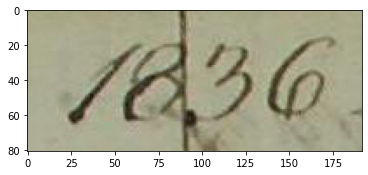

In [215]:
### Input image 

from matplotlib.pyplot import imshow

path=r'./DIDA_12000_String_Digit_Images/DIDA_1/1.jpg'
img=plt.imread(path)
print (img.shape)
imshow(img)

# ModelCC

### Data generation for ModelCC

In [14]:
# Datageneration for ModelCC

# Se https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255.,
    rotation_range=5,
    zoom_range=0.2,
)

datagen_test=ImageDataGenerator(rescale=1./255.)

train_generator_CC=datagen.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/train/DIDA_1",
x_col="Filename",
y_col="CC",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(32,64))

valid_generator_CC=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/val/DIDA_1",
x_col="Filename",
y_col="CC",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(32,64))

test_generator_CC=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/test/DIDA_1",
x_col="Filename",
y_col="CC",
batch_size=1200,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(32,64))



Found 8400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


### Build model

In [533]:
# Build ModelCC - first try

modelCC = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), #Neuron = number of classes
    ])

modelCC.compile(
    #optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelCC.summary()

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_368 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_292 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_369 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_293 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_370 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_294 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_106 (Flatten)        (None, 384)            

In [415]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

historyCC = modelCC.fit(train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80
)

modelCC.save('modelCC')

Epoch 1/80
262/262 [==============================] - 36s 124ms/step - loss: 0.1661 - accuracy: 0.9641 - val_loss: 0.1635 - val_accuracy: 0.9704
Epoch 2/80
262/262 [==============================] - 30s 114ms/step - loss: 0.1464 - accuracy: 0.9675 - val_loss: 0.1066 - val_accuracy: 0.9704
Epoch 3/80
262/262 [==============================] - 30s 115ms/step - loss: 0.1115 - accuracy: 0.9700 - val_loss: 0.0761 - val_accuracy: 0.9775
Epoch 4/80
262/262 [==============================] - 30s 115ms/step - loss: 0.0814 - accuracy: 0.9775 - val_loss: 0.0487 - val_accuracy: 0.9854
Epoch 5/80
262/262 [==============================] - 33s 126ms/step - loss: 0.0724 - accuracy: 0.9809 - val_loss: 0.0556 - val_accuracy: 0.9850
Epoch 6/80
262/262 [==============================] - 39s 150ms/step - loss: 0.0669 - accuracy: 0.9818 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 7/80
262/262 [==============================] - 38s 144ms/step - loss: 0.0623 - accuracy: 0.9816 - val_loss: 0.0354 - val_ac

### Evaluate model

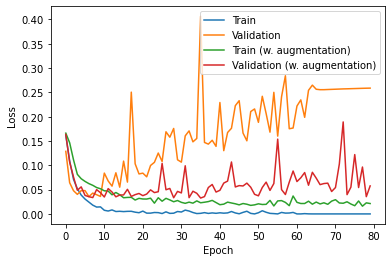

In [585]:
# Comparing loss: w/w.o. data augmentation

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.plot(historyCC.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyCC.history['val_loss'], label = 'Validation (w. augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

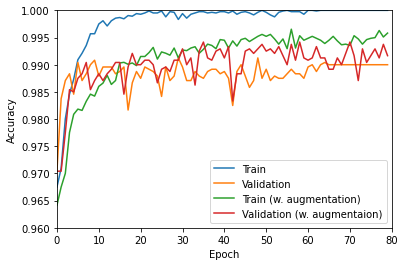

In [434]:
# Comparing accuracy: w/w.o. data augmentation

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.plot(historyCC.history['accuracy'], label = 'Train (w. augmentation)')
plt.plot(historyCC.history['val_accuracy'], label = 'Validation (w. augmentaion)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1.0])
plt.xlim([0,80])
plt.legend()


In [453]:
# Build with optimizer

modelCC = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), 
    ])

modelCC.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelCC.summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_329 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_253 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_254 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_331 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_255 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_93 (Flatten)         (None, 384)             

In [428]:
# Fit with optimizer
STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

historyCC_opt = modelCC.fit(train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80
)

modelCC.save('modelCC')

Epoch 1/80
262/262 [==============================] - 45s 158ms/step - loss: 0.1693 - accuracy: 0.9638 - val_loss: 0.1381 - val_accuracy: 0.9704
Epoch 2/80
262/262 [==============================] - 32s 122ms/step - loss: 0.1528 - accuracy: 0.9675 - val_loss: 0.1292 - val_accuracy: 0.9704
Epoch 3/80
262/262 [==============================] - 33s 126ms/step - loss: 0.1393 - accuracy: 0.9674 - val_loss: 0.1076 - val_accuracy: 0.9704
Epoch 4/80
262/262 [==============================] - 31s 116ms/step - loss: 0.1071 - accuracy: 0.9706 - val_loss: 0.1112 - val_accuracy: 0.9712
Epoch 5/80
262/262 [==============================] - 31s 116ms/step - loss: 0.0807 - accuracy: 0.9779 - val_loss: 0.0560 - val_accuracy: 0.9854
Epoch 6/80
262/262 [==============================] - 31s 119ms/step - loss: 0.0733 - accuracy: 0.9797 - val_loss: 0.0480 - val_accuracy: 0.9879
Epoch 7/80
262/262 [==============================] - 30s 114ms/step - loss: 0.0632 - accuracy: 0.9802 - val_loss: 0.0470 - val_ac

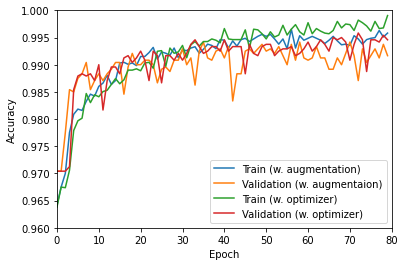

In [448]:
# Comparing accuracy:

# Nothing
#plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label = 'Validation')
# With data augmentation
plt.plot(historyCC.history['accuracy'], label = 'Train (w. augmentation)')
plt.plot(historyCC.history['val_accuracy'], label = 'Validation (w. augmentaion)')
# With data augmentation & optimizer
plt.plot(historyCC_opt.history['accuracy'], label = 'Train (w. optimizer)')
plt.plot(historyCC_opt.history['val_accuracy'], label = 'Validation (w. optimizer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1.0])
plt.xlim([0,80])
plt.legend()


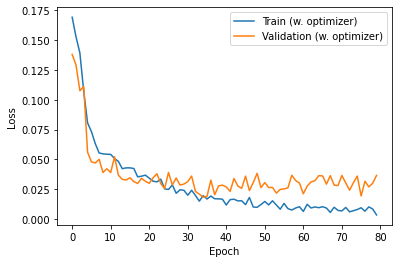

In [587]:
# Comparing loss

#plt.plot(history.history['loss'], label='Train')
#plt.plot(history.history['val_loss'], label = 'Validation')
#plt.plot(historyCC.history['loss'], label = 'Train (w. augmentation)')
#plt.plot(historyCC.history['val_loss'], label = 'Validation (w. augmentation)')
plt.plot(historyCC_opt.history['loss'], label = 'Train (w. optimizer)')
plt.plot(historyCC_opt.history['val_loss'], label = 'Validation (w. optimizer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [440]:
modelCC.evaluate(valid_generator_CC,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 4s 78ms/step - loss: 0.0241 - accuracy: 0.9958


[0.024133985862135887, 0.9957770109176636]

### Regularize modelCC

Model is still overfitting a bit. Now we regularize to control capacity.

In [534]:
# Early stopping to achieve best parameter settings
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callback = []
callback.append(reduce_lr)
callback.append(early_stopping)

# This callback will stop the training when there is no improvement in the loss for 5 consecutive epochs.

STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

historyCC_reg = modelCC.fit(train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)


Epoch 1/80
262/262 [==============================] - 33s 116ms/step - loss: 0.1650 - accuracy: 0.9675 - val_loss: 0.1979 - val_accuracy: 0.9704
Epoch 2/80
262/262 [==============================] - 30s 113ms/step - loss: 0.1322 - accuracy: 0.9675 - val_loss: 0.0805 - val_accuracy: 0.9746
Epoch 3/80
262/262 [==============================] - 31s 118ms/step - loss: 0.0981 - accuracy: 0.9738 - val_loss: 0.0638 - val_accuracy: 0.9846
Epoch 4/80
262/262 [==============================] - 31s 118ms/step - loss: 0.0761 - accuracy: 0.9788 - val_loss: 0.0565 - val_accuracy: 0.9862
Epoch 5/80
262/262 [==============================] - 32s 122ms/step - loss: 0.0697 - accuracy: 0.9812 - val_loss: 0.0514 - val_accuracy: 0.9867
Epoch 6/80
262/262 [==============================] - 32s 123ms/step - loss: 0.0645 - accuracy: 0.9818 - val_loss: 0.0459 - val_accuracy: 0.9887
Epoch 7/80
262/262 [==============================] - 30s 115ms/step - loss: 0.0596 - accuracy: 0.9835 - val_loss: 0.0453 - val_ac

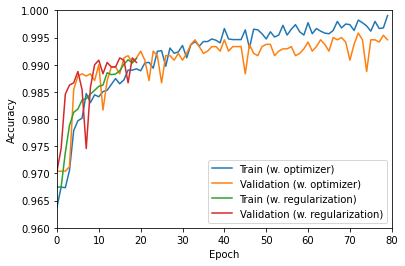

In [822]:
# Comparing accuracy:

# Nothing
#plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label = 'Validation')
# With data augmentation
#plt.plot(historyCC.history['accuracy'], label = 'Train (w. augmentation)')
#plt.plot(historyCC.history['val_accuracy'], label = 'Validation (w. augmentaion)')
# With data augmentation & optimizer
plt.plot(historyCC_opt.history['accuracy'], label = 'Train (w. optimizer)')
plt.plot(historyCC_opt.history['val_accuracy'], label = 'Validation (w. optimizer)')
# With regularization
plt.plot(historyCC_reg.history['accuracy'], label = 'Train (w. regularization)')
plt.plot(historyCC_reg.history['val_accuracy'], label = 'Validation (w. regularization)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1.0])
plt.xlim([0,80])
plt.legend()


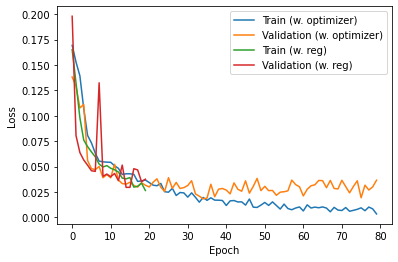

In [586]:
# Comparing loss

#plt.plot(history.history['loss'], label='Train')
#plt.plot(history.history['val_loss'], label = 'Validation')
#plt.plot(historyCC.history['loss'], label = 'Train (w. augmentation)')
#plt.plot(historyCC.history['val_loss'], label = 'Validation (w. augmentation)')
plt.plot(historyCC_opt.history['loss'], label = 'Train (w. optimizer)')
plt.plot(historyCC_opt.history['val_loss'], label = 'Validation (w. optimizer)')
plt.plot(historyCC_reg.history['loss'], label = 'Train (w. reg)')
plt.plot(historyCC_reg.history['val_loss'], label = 'Validation (w. reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [463]:
modelCC.evaluate(valid_generator_CC,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 2s 41ms/step - loss: 0.0405 - accuracy: 0.9916


[0.04050736874341965, 0.9915540814399719]

In [498]:
modelCC.evaluate(test_generator_CC,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 2s 49ms/step - loss: 0.0556 - accuracy: 0.9916


[0.05564853176474571, 0.9915540814399719]

In [464]:
modelCC.save('modelCC')

INFO:tensorflow:Assets written to: modelCC/assets


# ModelD

### Data generation for ModelD

In [15]:
# Datageneration for ModelD

# Se https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_generator_D=datagen.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/train/DIDA_1",
x_col="Filename",
y_col="D",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64))

valid_generator_D=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/val/DIDA_1",
x_col="Filename",
y_col="D",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64))

test_generator_D=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/test/DIDA_1",
x_col="Filename",
y_col="D",
batch_size=1200,
seed=42,
shuffle=False,
class_mode="sparse",
target_size=(32,64))


Found 8400 validated image filenames belonging to 11 classes.
Found 2400 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


### Build model

In [526]:
# Build ModelD - first try with shallow model similar to ModelCC

modelD = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'), # softmax for multiple classes
    ])

modelD.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelD.summary()

modelD.save('modelD')


Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_365 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_289 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_366 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_290 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_367 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_291 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_105 (Flatten)        (None, 384)            

In [485]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_D.n//train_generator_D.batch_size
STEP_SIZE_VALID=valid_generator_D.n//valid_generator_D.batch_size
STEP_SIZE_TEST=test_generator_D.n//test_generator_D.batch_size

historyD_opt = modelD.fit(train_generator_D,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_D,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)


Epoch 1/50
262/262 [==============================] - 52s 189ms/step - loss: 1.6326 - accuracy: 0.0924 - val_loss: 1.5986 - val_accuracy: 0.0000e+00
Epoch 2/50
262/262 [==============================] - 38s 145ms/step - loss: 1.5918 - accuracy: 0.0503 - val_loss: 1.5234 - val_accuracy: 0.1825
Epoch 3/50
262/262 [==============================] - 107s 411ms/step - loss: 1.3438 - accuracy: 0.1908 - val_loss: 0.9579 - val_accuracy: 0.1963
Epoch 4/50
262/262 [==============================] - 37s 141ms/step - loss: 0.9277 - accuracy: 0.1887 - val_loss: 0.7530 - val_accuracy: 0.2296
Epoch 5/50
262/262 [==============================] - 40s 154ms/step - loss: 0.7355 - accuracy: 0.1926 - val_loss: 0.6050 - val_accuracy: 0.2325
Epoch 6/50
262/262 [==============================] - 36s 138ms/step - loss: 0.6200 - accuracy: 0.1936 - val_loss: 0.5140 - val_accuracy: 0.2154
Epoch 7/50
262/262 [==============================] - 41s 157ms/step - loss: 0.5585 - accuracy: 0.2004 - val_loss: 0.4694 - v

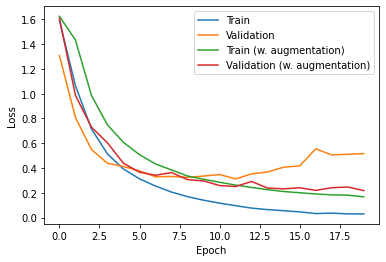

In [478]:
# Comparing loss: w/w.o. data augmentation

# Nothing
plt.plot(historyD.history['loss'], label='Train')
plt.plot(historyD.history['val_loss'], label = 'Validation')
# with DA
plt.plot(historyD_da.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyD_da.history['val_loss'], label = 'Validation (w. augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

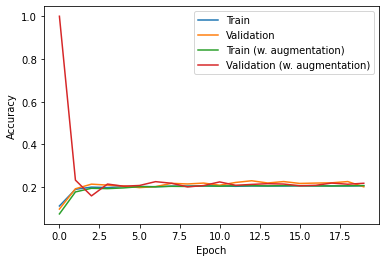

In [489]:
# Comparing accuracy:

plt.plot(historyD.history['accuracy'], label='Train')
plt.plot(historyD.history['val_accuracy'], label = 'Validation')
plt.plot(historyD_da.history['accuracy'], label='Train (w. augmentation)')
plt.plot(historyD_da.history['val_accuracy'], label = 'Validation (w. augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


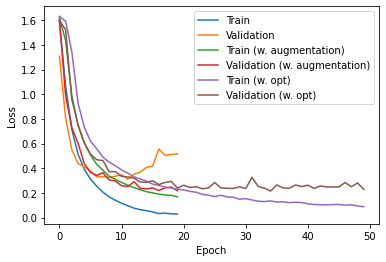

In [487]:
# Compare models - without or with optimizer
# Loss
# Nothing
plt.plot(historyD.history['loss'], label='Train')
plt.plot(historyD.history['val_loss'], label = 'Validation')
# with DA
plt.plot(historyD_da.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyD_da.history['val_loss'], label = 'Validation (w. augmentation)')
# With opt
plt.plot(historyD_opt.history['loss'], label = 'Train (w. opt)')
plt.plot(historyD_opt.history['val_loss'], label = 'Validation (w. opt)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

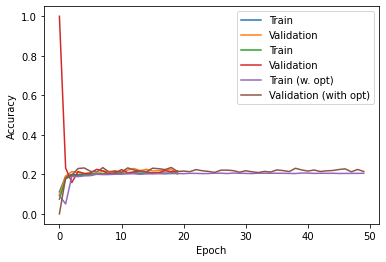

In [488]:
# Comparing accuracy:

plt.plot(historyD.history['accuracy'], label='Train')
plt.plot(historyD.history['val_accuracy'], label = 'Validation')
plt.plot(historyD_da.history['accuracy'], label='Train (w. augmentation)')
plt.plot(historyD_da.history['val_accuracy'], label = 'Validation (w. augmentation)')
plt.plot(historyD_opt.history['accuracy'], label = 'Train (w. opt)')
plt.plot(historyD_opt.history['val_accuracy'], label = 'Validation (with opt)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


### Regularize modelD

Model is still overfitting a bit. Now we regularize to control capacity.

In [527]:
# Early stopping to achieve best parameter settings
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callback = []
callback.append(reduce_lr)
callback.append(early_stopping)

# This callback will stop the training when there is no improvement in the loss for 5 consecutive epochs.

STEP_SIZE_TRAIN=train_generator_D.n//train_generator_D.batch_size
STEP_SIZE_VALID=valid_generator_D.n//valid_generator_D.batch_size
STEP_SIZE_TEST=test_generator_D.n//test_generator_D.batch_size

historyD_reg = modelD.fit(train_generator_D,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_D,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)


Epoch 1/80
262/262 [==============================] - 60s 217ms/step - loss: 1.6277 - accuracy: 0.0700 - val_loss: 1.5880 - val_accuracy: 0.0000e+00
Epoch 2/80
262/262 [==============================] - 49s 186ms/step - loss: 1.5292 - accuracy: 0.0850 - val_loss: 1.1618 - val_accuracy: 0.2050
Epoch 3/80
262/262 [==============================] - 52s 197ms/step - loss: 1.0789 - accuracy: 0.1984 - val_loss: 0.8090 - val_accuracy: 0.1887
Epoch 4/80
262/262 [==============================] - 53s 200ms/step - loss: 0.8630 - accuracy: 0.1935 - val_loss: 0.6444 - val_accuracy: 0.1750
Epoch 5/80
262/262 [==============================] - 50s 191ms/step - loss: 0.7097 - accuracy: 0.1941 - val_loss: 0.5333 - val_accuracy: 0.2017
Epoch 6/80
262/262 [==============================] - 55s 210ms/step - loss: 0.6034 - accuracy: 0.1950 - val_loss: 0.4799 - val_accuracy: 0.2154
Epoch 7/80
262/262 [==============================] - 58s 220ms/step - loss: 0.5329 - accuracy: 0.1986 - val_loss: 0.5078 - va

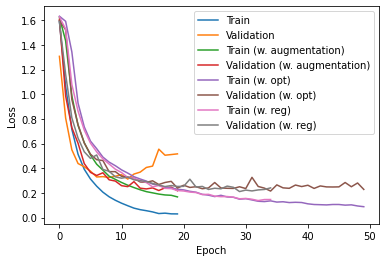

In [528]:
# Compare models - with regularization
# Loss
# Nothing
plt.plot(historyD.history['loss'], label='Train')
plt.plot(historyD.history['val_loss'], label = 'Validation')
# with DA
plt.plot(historyD_da.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyD_da.history['val_loss'], label = 'Validation (w. augmentation)')
# With opt
plt.plot(historyD_opt.history['loss'], label = 'Train (w. opt)')
plt.plot(historyD_opt.history['val_loss'], label = 'Validation (w. opt)')
#with reg
plt.plot(historyD_reg.history['loss'], label = 'Train (w. reg)')
plt.plot(historyD_reg.history['val_loss'], label = 'Validation (w. reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

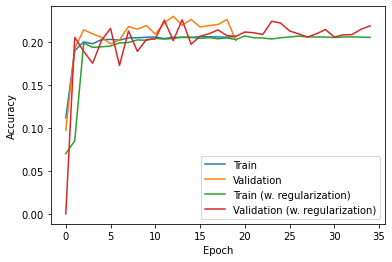

In [529]:
# Comparing accuracy:

# Nothing
plt.plot(historyD.history['accuracy'], label='Train')
plt.plot(historyD.history['val_accuracy'], label = 'Validation')
# With data augmentation
#plt.plot(historyD_da.history['accuracy'], label = 'Train (w. augmentation)')
#plt.plot(historyD_da.history['val_accuracy'], label = 'Validation (w. augmentaion)')
# With data augmentation & optimizer
#plt.plot(historyD_opt.history['accuracy'], label = 'Train (w. optimizer)')
#plt.plot(historyD_opt.history['val_accuracy'], label = 'Validation (w. optimizer)')
# With regularization
plt.plot(historyD_reg.history['accuracy'], label = 'Train (w. regularization)')
plt.plot(historyD_reg.history['val_accuracy'], label = 'Validation (w. regularization)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [530]:
modelD.save('modelD')

INFO:tensorflow:Assets written to: modelD/assets


In [531]:
modelD.evaluate(valid_generator_D,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 2s 47ms/step - loss: 0.1884 - accuracy: 0.2204


[0.1884235441684723, 0.22043919563293457]

In [702]:
modelD.evaluate(test_generator_D,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 2s 2s/step - loss: 0.2967 - accuracy: 0.2158


[0.2967057228088379, 0.21583333611488342]

### ModelY

In [16]:
# Datageneration for ModelY

# Se https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255.,
    rotation_range=5,
    zoom_range=0.2
    )

datagen_test=ImageDataGenerator(rescale=1./255.)

train_generator_Y=datagen.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/train/DIDA_1",
x_col="Filename",
y_col="Y",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64)
)

valid_generator_Y=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/val/DIDA_1",
x_col="Filename",
y_col="Y",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64)
)

test_generator_Y=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/test/DIDA_1",
x_col="Filename",
y_col="Y",
batch_size=1200,
seed=42,
shuffle=False,
class_mode="sparse",
target_size=(32,64)
)

Found 8400 validated image filenames belonging to 11 classes.
Found 2400 validated image filenames belonging to 11 classes.
Found 1200 validated image filenames belonging to 11 classes.


In [519]:
# Build ModelY - first try with shallow model similar to ModelCC

modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'), # softmax for multiple classes
    ])

modelY.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelY.summary()

modelY.save('modelY')


Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_362 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_286 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_363 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_287 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_364 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_288 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_104 (Flatten)        (None, 384)            

In [509]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_Y.n//train_generator_Y.batch_size
STEP_SIZE_VALID=valid_generator_Y.n//valid_generator_Y.batch_size
STEP_SIZE_TEST=test_generator_Y.n//test_generator_Y.batch_size

historyY_opt = modelY.fit(train_generator_Y,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_Y,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
262/262 [==============================] - 38s 133ms/step - loss: 2.3693 - accuracy: 0.8353 - val_loss: 2.3544 - val_accuracy: 0.5896
Epoch 2/20
262/262 [==============================] - 31s 118ms/step - loss: 2.1857 - accuracy: 0.3052 - val_loss: 1.8983 - val_accuracy: 0.0742
Epoch 3/20
262/262 [==============================] - 32s 122ms/step - loss: 1.7585 - accuracy: 0.1414 - val_loss: 1.3747 - val_accuracy: 0.1187
Epoch 4/20
262/262 [==============================] - 33s 126ms/step - loss: 1.3632 - accuracy: 0.1217 - val_loss: 1.2227 - val_accuracy: 0.1729
Epoch 5/20
262/262 [==============================] - 34s 130ms/step - loss: 1.1549 - accuracy: 0.1240 - val_loss: 0.9850 - val_accuracy: 0.1329
Epoch 6/20
262/262 [==============================] - 38s 146ms/step - loss: 1.0227 - accuracy: 0.1214 - val_loss: 0.9386 - val_accuracy: 0.1300
Epoch 7/20
262/262 [==============================] - 44s 167ms/step - loss: 0.9110 - accuracy: 0.1237 - val_loss: 0.8713 - val_ac

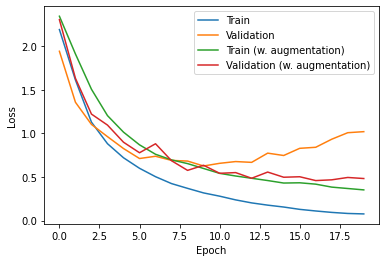

In [505]:
# Comparing loss: w/w.o. data augmentation

# Nothing
plt.plot(historyY.history['loss'], label='Train')
plt.plot(historyY.history['val_loss'], label = 'Validation')
# with DA
plt.plot(historyY_da.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyY_da.history['val_loss'], label = 'Validation (w. augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

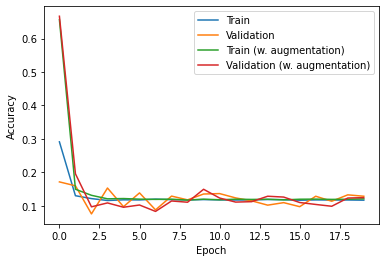

In [506]:
# Comparing accuracy:

plt.plot(historyY.history['accuracy'], label='Train')
plt.plot(historyY.history['val_accuracy'], label = 'Validation')
plt.plot(historyY_da.history['accuracy'], label='Train (w. augmentation)')
plt.plot(historyY_da.history['val_accuracy'], label = 'Validation (w. augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

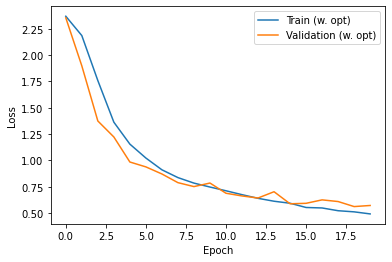

In [511]:
# Compare models - without or with optimizer
# Loss
# Nothing
plt.plot(historyY.history['loss'], label='Train')
plt.plot(historyY.history['val_loss'], label = 'Validation')
# with DA
plt.plot(historyY_da.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyY_da.history['val_loss'], label = 'Validation (w. augmentation)')
# With opt
plt.plot(historyY_opt.history['loss'], label = 'Train (w. opt)')
plt.plot(historyY_opt.history['val_loss'], label = 'Validation (w. opt)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

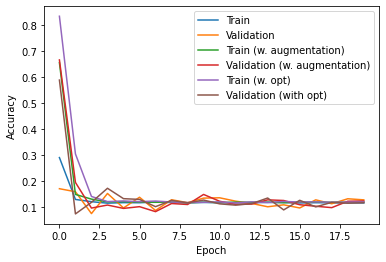

In [512]:
# Comparing accuracy:

plt.plot(historyY.history['accuracy'], label='Train')
plt.plot(historyY.history['val_accuracy'], label = 'Validation')
plt.plot(historyY_da.history['accuracy'], label='Train (w. augmentation)')
plt.plot(historyY_da.history['val_accuracy'], label = 'Validation (w. augmentation)')
plt.plot(historyY_opt.history['accuracy'], label = 'Train (w. opt)')
plt.plot(historyY_opt.history['val_accuracy'], label = 'Validation (with opt)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


### Regularize modelY

Model seems to be overfitting a bit. Now we regularize to control capacity and give it more time to train.

In [520]:
# Early stopping to achieve best parameter settings
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callback = []
callback.append(reduce_lr)
callback.append(early_stopping)

STEP_SIZE_TRAIN=train_generator_Y.n//train_generator_Y.batch_size
STEP_SIZE_VALID=valid_generator_Y.n//valid_generator_Y.batch_size
STEP_SIZE_TEST=test_generator_Y.n//test_generator_Y.batch_size

historyY_reg = modelY.fit(train_generator_D,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_D,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)


Epoch 1/80
262/262 [==============================] - 65s 222ms/step - loss: 1.6327 - accuracy: 0.1170 - val_loss: 1.6025 - val_accuracy: 4.1667e-04
Epoch 2/80
262/262 [==============================] - 39s 147ms/step - loss: 1.4837 - accuracy: 0.1347 - val_loss: 1.2172 - val_accuracy: 0.1813
Epoch 3/80
262/262 [==============================] - 41s 158ms/step - loss: 1.0564 - accuracy: 0.1940 - val_loss: 0.8932 - val_accuracy: 0.1854
Epoch 4/80
262/262 [==============================] - 48s 181ms/step - loss: 0.8270 - accuracy: 0.1920 - val_loss: 0.6226 - val_accuracy: 0.2071
Epoch 5/80
262/262 [==============================] - 40s 154ms/step - loss: 0.6711 - accuracy: 0.1969 - val_loss: 0.5199 - val_accuracy: 0.1762
Epoch 6/80
262/262 [==============================] - 43s 164ms/step - loss: 0.5551 - accuracy: 0.1981 - val_loss: 0.4601 - val_accuracy: 0.2379
Epoch 7/80
262/262 [==============================] - 39s 147ms/step - loss: 0.4961 - accuracy: 0.2023 - val_loss: 0.3902 - va

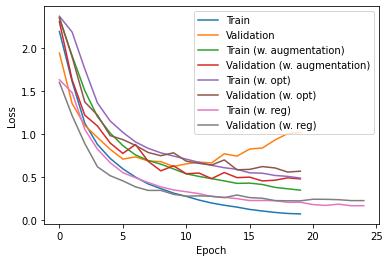

In [521]:
# Compare models - with regularization
# Loss
# Nothing
plt.plot(historyY.history['loss'], label='Train')
plt.plot(historyY.history['val_loss'], label = 'Validation')
# with DA
plt.plot(historyY_da.history['loss'], label = 'Train (w. augmentation)')
plt.plot(historyY_da.history['val_loss'], label = 'Validation (w. augmentation)')
# With opt
plt.plot(historyY_opt.history['loss'], label = 'Train (w. opt)')
plt.plot(historyY_opt.history['val_loss'], label = 'Validation (w. opt)')
#with reg
plt.plot(historyY_reg.history['loss'], label = 'Train (w. reg)')
plt.plot(historyY_reg.history['val_loss'], label = 'Validation (w. reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

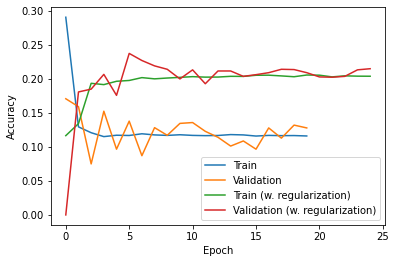

In [522]:
# Comparing accuracy:

# Nothing
plt.plot(historyY.history['accuracy'], label='Train')
plt.plot(historyY.history['val_accuracy'], label = 'Validation')
# With data augmentation
#plt.plot(historyY_da.history['accuracy'], label = 'Train (w. augmentation)')
#plt.plot(historyY_da.history['val_accuracy'], label = 'Validation (w. augmentaion)')
# With data augmentation & optimizer
plt.plot(historyY_opt.history['accuracy'], label = 'Train (w. optimizer)')
plt.plot(historyY_opt.history['val_accuracy'], label = 'Validation (w. optimizer)')
# With regularization
plt.plot(historyY_reg.history['accuracy'], label = 'Train (w. regularization)')
plt.plot(historyY_reg.history['val_accuracy'], label = 'Validation (w. regularization)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [523]:
modelY.save('modelY')

INFO:tensorflow:Assets written to: modelY/assets


In [524]:
modelY.evaluate(valid_generator_D,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 3s 72ms/step - loss: 0.1966 - accuracy: 0.2204


[0.19655992090702057, 0.22043919563293457]

In [525]:
modelY.evaluate(test_generator_D,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 6s 153ms/step - loss: 0.2812 - accuracy: 0.2111


[0.2811799943447113, 0.21114864945411682]

## Transfer learning

In [589]:
# Loading the pre-trained model

pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(32, 64, 3), 
    include_top=False, 
    weights='imagenet', 
)

pre_trained_model.trainable = False 

pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 32, 32)   864         input_38[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 16, 32, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [590]:
# Transfer learning - modelCC

modelCC_tl = tf.keras.models.Sequential([
    pre_trained_model, # the pre-trained part
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax'),
    ])
modelCC_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelCC_tl.summary()

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1, 2, 1280)        2257984   
_________________________________________________________________
flatten_118 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_228 (Dense)            (None, 64)                163904    
_________________________________________________________________
dense_229 (Dense)            (None, 2)                 130       
Total params: 2,422,018
Trainable params: 164,034
Non-trainable params: 2,257,984
_________________________________________________________________


In [591]:
# Fit
historyCC_tl = modelCC_tl.fit(train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)

modelCC_tl.save('modelCC_tl')

Epoch 1/80
262/262 [==============================] - 32s 89ms/step - loss: 0.1009 - accuracy: 0.9728 - val_loss: 0.0611 - val_accuracy: 0.9817
Epoch 2/80
262/262 [==============================] - 21s 80ms/step - loss: 0.0726 - accuracy: 0.9809 - val_loss: 0.0537 - val_accuracy: 0.9858
Epoch 3/80
262/262 [==============================] - 18s 69ms/step - loss: 0.0643 - accuracy: 0.9824 - val_loss: 0.0516 - val_accuracy: 0.9862
Epoch 4/80
262/262 [==============================] - 21s 80ms/step - loss: 0.0586 - accuracy: 0.9828 - val_loss: 0.0501 - val_accuracy: 0.9867
Epoch 5/80
262/262 [==============================] - 21s 80ms/step - loss: 0.0579 - accuracy: 0.9836 - val_loss: 0.0504 - val_accuracy: 0.9867
Epoch 6/80
262/262 [==============================] - 21s 81ms/step - loss: 0.0568 - accuracy: 0.9824 - val_loss: 0.0507 - val_accuracy: 0.9846
Epoch 7/80
262/262 [==============================] - 20s 78ms/step - loss: 0.0515 - accuracy: 0.9853 - val_loss: 0.0533 - val_accuracy:

INFO:tensorflow:Assets written to: modelCC_tl/assets


INFO:tensorflow:Assets written to: modelCC_tl/assets
/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


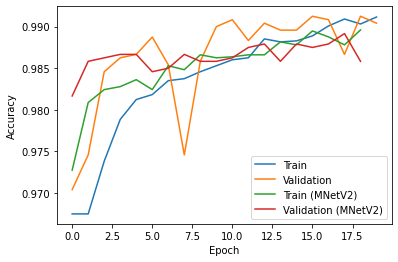

In [638]:
# Comparing accuracy:

# Nothing
#plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label = 'Validation')
# With data augmentation
#plt.plot(historyCC.history['accuracy'], label = 'Train (w. augmentation)')
#plt.plot(historyCC.history['val_accuracy'], label = 'Validation (w. augmentaion)')
# With data augmentation & optimizer
#plt.plot(historyCC_opt.history['accuracy'], label = 'Train (w. optimizer)')
#plt.plot(historyCC_opt.history['val_accuracy'], label = 'Validation (w. optimizer)')
# With regularization
plt.plot(historyCC_reg.history['accuracy'], label = 'Train')
plt.plot(historyCC_reg.history['val_accuracy'], label = 'Validation')
# With transfer learning
plt.plot(historyCC_tl.history['accuracy'], label = 'Train (MNetV2)')
plt.plot(historyCC_tl.history['val_accuracy'], label = 'Validation (MNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.96, 1.0])
#plt.xlim([0,80])
plt.legend()


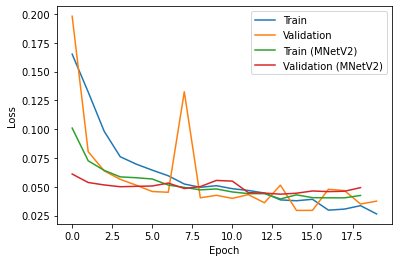

In [637]:
# Comparing loss

#plt.plot(history.history['loss'], label='Train')
#plt.plot(history.history['val_loss'], label = 'Validation')
#plt.plot(historyCC.history['loss'], label = 'Train (w. augmentation)')
#plt.plot(historyCC.history['val_loss'], label = 'Validation (w. augmentation)')
#plt.plot(historyCC_opt.history['loss'], label = 'Train (w. optimizer)')
#plt.plot(historyCC_opt.history['val_loss'], label = 'Validation (w. optimizer)')
plt.plot(historyCC_reg.history['loss'], label = 'Train')
plt.plot(historyCC_reg.history['val_loss'], label = 'Validation')
plt.plot(historyCC_tl.history['loss'], label = 'Train (MNetV2)')
plt.plot(historyCC_tl.history['val_loss'], label = 'Validation (MNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [566]:
# Transfer learning - modelD

modelD_tl = tf.keras.models.Sequential([
    pre_trained_model, # the pre-trained part
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.5),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])
modelD_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelD_tl.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1, 2, 1280)        2257984   
_________________________________________________________________
flatten_116 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_224 (Dense)            (None, 64)                163904    
_________________________________________________________________
dense_225 (Dense)            (None, 11)                715       
Total params: 2,422,603
Trainable params: 164,619
Non-trainable params: 2,257,984
_________________________________________________________________


In [567]:
# Fit
historyD_tl = modelD_tl.fit(train_generator_D,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_D,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)

modelD_tl.save('modelD_tl')

Epoch 1/80
262/262 [==============================] - 42s 120ms/step - loss: 1.5051 - accuracy: 0.3558 - val_loss: 1.3940 - val_accuracy: 0.3892
Epoch 2/80
262/262 [==============================] - 29s 113ms/step - loss: 1.3720 - accuracy: 0.4226 - val_loss: 1.3610 - val_accuracy: 0.4154
Epoch 3/80
262/262 [==============================] - 29s 111ms/step - loss: 1.3507 - accuracy: 0.4327 - val_loss: 1.3567 - val_accuracy: 0.4296
Epoch 4/80
262/262 [==============================] - 27s 104ms/step - loss: 1.3175 - accuracy: 0.4468 - val_loss: 1.3458 - val_accuracy: 0.4367
Epoch 5/80
262/262 [==============================] - 26s 101ms/step - loss: 1.2962 - accuracy: 0.4588 - val_loss: 1.2987 - val_accuracy: 0.4546
Epoch 6/80
262/262 [==============================] - 25s 97ms/step - loss: 1.2719 - accuracy: 0.4760 - val_loss: 1.3100 - val_accuracy: 0.4512
Epoch 7/80
262/262 [==============================] - 29s 111ms/step - loss: 1.2634 - accuracy: 0.4765 - val_loss: 1.2957 - val_acc

INFO:tensorflow:Assets written to: modelD_tl/assets


INFO:tensorflow:Assets written to: modelD_tl/assets
/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


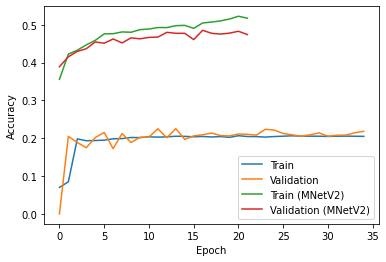

In [639]:
# Comparing accuracy:

# Nothing
#plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label = 'Validation')
# With data augmentation
#plt.plot(historyD.history['accuracy'], label = 'Train (w. augmentation)')
#plt.plot(historyD.history['val_accuracy'], label = 'Validation (w. augmentaion)')
# With data augmentation & optimizer
#plt.plot(historyD_opt.history['accuracy'], label = 'Train (w. optimizer)')
#plt.plot(historyD_opt.history['val_accuracy'], label = 'Validation (w. optimizer)')
# With regularization
plt.plot(historyD_reg.history['accuracy'], label = 'Train')
plt.plot(historyD_reg.history['val_accuracy'], label = 'Validation')
# With transfer learning
plt.plot(historyD_tl.history['accuracy'], label = 'Train (MNetV2)')
plt.plot(historyD_tl.history['val_accuracy'], label = 'Validation (MNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

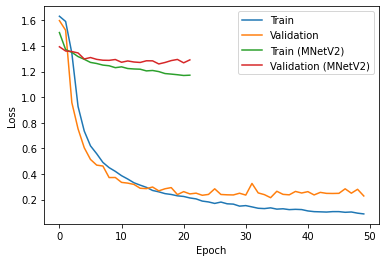

In [640]:
# Comparing loss

#plt.plot(history.history['loss'], label='Train')
#plt.plot(history.history['val_loss'], label = 'Validation')
#plt.plot(historyCC.history['loss'], label = 'Train (w. augmentation)')
#plt.plot(historyCC.history['val_loss'], label = 'Validation (w. augmentation)')
plt.plot(historyD_opt.history['loss'], label = 'Train')
plt.plot(historyD_opt.history['val_loss'], label = 'Validation')
plt.plot(historyD_tl.history['loss'], label = 'Train (MNetV2)')
plt.plot(historyD_tl.history['val_loss'], label = 'Validation (MNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [635]:
# ModelY
modelY_tl = tf.keras.models.Sequential([
    pre_trained_model, # the pre-trained part
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])
modelY_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelY_tl.summary()

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1, 2, 1280)        2257984   
_________________________________________________________________
flatten_120 (Flatten)        (None, 2560)              0         
_________________________________________________________________
dense_232 (Dense)            (None, 64)                163904    
_________________________________________________________________
dense_233 (Dense)            (None, 11)                715       
Total params: 2,422,603
Trainable params: 164,619
Non-trainable params: 2,257,984
_________________________________________________________________


In [636]:
# Fit
historyY_tl = modelY_tl.fit(train_generator_Y,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_Y,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)

modelY_tl.save('modelY_tl')

Epoch 1/80
262/262 [==============================] - 24s 82ms/step - loss: 2.2289 - accuracy: 0.2077 - val_loss: 2.0777 - val_accuracy: 0.2675
Epoch 2/80
262/262 [==============================] - 18s 69ms/step - loss: 1.9785 - accuracy: 0.2988 - val_loss: 1.9203 - val_accuracy: 0.3229
Epoch 3/80
262/262 [==============================] - 19s 73ms/step - loss: 1.8775 - accuracy: 0.3391 - val_loss: 1.8779 - val_accuracy: 0.3558
Epoch 4/80
262/262 [==============================] - 18s 70ms/step - loss: 1.8306 - accuracy: 0.3538 - val_loss: 1.8273 - val_accuracy: 0.3667
Epoch 5/80
262/262 [==============================] - 20s 77ms/step - loss: 1.7986 - accuracy: 0.3602 - val_loss: 1.8279 - val_accuracy: 0.3600
Epoch 6/80
262/262 [==============================] - 19s 73ms/step - loss: 1.7513 - accuracy: 0.3884 - val_loss: 1.8182 - val_accuracy: 0.3650
Epoch 7/80
262/262 [==============================] - 20s 78ms/step - loss: 1.7337 - accuracy: 0.3947 - val_loss: 1.8582 - val_accuracy:

INFO:tensorflow:Assets written to: modelY_tl/assets


INFO:tensorflow:Assets written to: modelY_tl/assets
/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


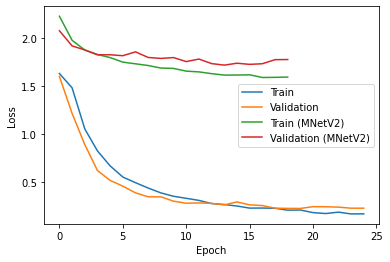

In [641]:
#with reg
plt.plot(historyY_reg.history['loss'], label = 'Train')
plt.plot(historyY_reg.history['val_loss'], label = 'Validation')
#with TL
plt.plot(historyY_tl.history['loss'], label = 'Train (MNetV2)')
plt.plot(historyY_tl.history['val_loss'], label = 'Validation (MNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

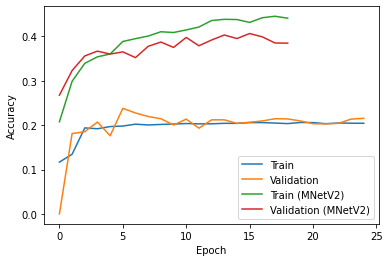

In [642]:
# With regularization
plt.plot(historyY_reg.history['accuracy'], label = 'Train')
plt.plot(historyY_reg.history['val_accuracy'], label = 'Validation')
# With transfer learning
plt.plot(historyY_tl.history['accuracy'], label = 'Train (MNetV2)')
plt.plot(historyY_tl.history['val_accuracy'], label = 'Validation (MNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [665]:
modelCC_tl.evaluate(test_generator_CC,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 2s 2s/step - loss: 0.0557 - accuracy: 0.9858


[0.05571187287569046, 0.9858333468437195]

In [666]:
# Compared to ModelCC
modelCC.evaluate(test_generator_CC,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 2s 2s/step - loss: 0.0547 - accuracy: 0.9892


[0.05474688112735748, 0.9891666769981384]

In [687]:
modelD_tl.evaluate(test_generator_D,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 2s 2s/step - loss: 1.3054 - accuracy: 0.4517


[1.3053908348083496, 0.4516666531562805]

In [710]:
# Compared to ModelD
modelD.evaluate(test_generator_D,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 2s 2s/step - loss: 0.2967 - accuracy: 0.2158


[0.2967057228088379, 0.21583333611488342]

In [669]:
modelY_tl.evaluate(test_generator_Y,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 2s 2s/step - loss: 1.7619 - accuracy: 0.3967


[1.7618860006332397, 0.39666667580604553]

In [670]:
# Compared to ModelY
modelY.evaluate(test_generator_Y,
steps=STEP_SIZE_TEST)

1/1 [==============================] - 1s 1s/step - loss: 13.7870 - accuracy: 0.2092


[13.786972999572754, 0.20916666090488434]

## Accuracy metrics

In [18]:
# Comparing accuracy of models

modelCC = tf.keras.models.load_model("./ModelCC")
modelD_tl = tf.keras.models.load_model("./ModelD_tl")
modelY_tl = tf.keras.models.load_model("./ModelY_tl")

# ModelCC
X_test, y_test = next(test_generator_CC)
real_labels_CC = y_test
real_labels_CC = real_labels_CC.astype(int)
predictions = modelCC.predict(X_test)
predict_labels_CC = np.argmax(predictions, axis=-1)

# ModelD
X_test, y_test = next(test_generator_D)
real_labels_D = y_test
real_labels_D = real_labels_D.astype(int)
predictions = modelD_tl.predict(X_test)
predict_labels_D = np.argmax(predictions, axis=-1)

# ModelY
X_test, y_test = next(test_generator_Y)
real_labels_Y = y_test
real_labels_Y=real_labels_Y.astype(int)
predictions = modelY_tl.predict(X_test)
predict_labels_Y = np.argmax(predictions, axis=-1)

# Predictions
p1=(predict_labels_CC==real_labels_CC)
p2=(predict_labels_D==real_labels_D)
p3=(predict_labels_Y==real_labels_Y)

CNN_p_CC = 0
for i in range(len(predict_labels_CC)):
    if p1[i] == True:
        CNN_p_CC = CNN_p_CC + 1
CNN_p_D = 0
for i in range(len(predict_labels_D)):
    if p2[i] == True:
        CNN_p_D = CNN_p_D + 1
CNN_p_Y = 0
for i in range(len(predict_labels_Y)):
    if p3[i] == True:
        CNN_p_Y = CNN_p_Y + 1

CNN_p_sequence = 0
for i in range(len(p1)):
    if p1[i] == p2[i] == p3[i] == True:
       CNN_p_sequence = CNN_p_sequence + 1

CNN_p_character = round(CNN_p_CC*0.33 + CNN_p_D*0.33 + CNN_p_Y*0.33)
    
print('point for CC-model:', round(CNN_p_CC*(1/3)))
print('point for D-model:', round(CNN_p_D*(1/3)))
print('point for Y-model:', round(CNN_p_Y*(1/3)))
print('point for character acc:', CNN_p_character, 'out of', len(real_labels_CC))
print('point for correct sequence:', CNN_p_sequence, 'out of', len(real_labels_CC))

point for CC-model: 397
point for D-model: 181
point for Y-model: 159
point for character acc: 729 out of 1200
point for correct sequence: 225 out of 1200


# Question 3

Investigate if your model’s performance is particularly good or bad at correctly  classifying certain classes (i.e., it might be very good at correctly classifying centuries  but not years, or it might be good at correctly classifying  some decades but not certain other decades). Does it mix up  certain classes? If yes, does this surprise you (explain why or why not)?

In [736]:
# Which labels are easy/hard to predict

from collections import Counter

# What are wrong predictions
n_list = []
for i in range(len(real_labels_CC)):
    if predict_labels_CC[i] != real_labels_CC[i]:
        n_list.append(predict_labels_CC[i])
        
print(len(n_list))

nn_list = []
for i in range(len(real_labels_D)):
    if predict_labels_D[i] != real_labels_D[i]:
        nn_list.append(predict_labels_D[i])
        
print(len(nn_list))

nnn_list = []
for i in range(len(real_labels_Y)):
    if predict_labels_Y[i] != real_labels_Y[i]:
        nnn_list.append(predict_labels_Y[i])
        
print(len(nnn_list))

print("CC:", Counter(n_list))
print("D:", Counter(nn_list))
print("Y:", Counter(nnn_list))

13
658
724
CC: Counter({0: 10, 1: 3})
D: Counter({4: 208, 3: 167, 1: 144, 0: 116, 5: 20, 2: 3})
Y: Counter({0: 148, 8: 101, 7: 83, 10: 81, 6: 69, 5: 66, 3: 65, 1: 45, 4: 33, 9: 27, 2: 6})


In [22]:
# Which classes are hard to classify?

from collections import Counter

c_list = []
for i in range(len(real_labels_CC)):
    if predict_labels_CC[i] != real_labels_CC[i]:
        c_list.append(real_labels_CC[i])
        
print(len(c_list))

cc_list = []
for i in range(len(real_labels_D)):
    if predict_labels_D[i] != real_labels_D[i]:
        cc_list.append(real_labels_D[i])
        
print(len(cc_list))

ccc_list = []
for i in range(len(real_labels_Y)):
    if predict_labels_Y[i] != real_labels_Y[i]:
        ccc_list.append(real_labels_Y[i])
        
print(len(ccc_list))

print("CC:", Counter(c_list))
print("D:", Counter(cc_list))
print("Y:", Counter(ccc_list))

10
658
724
CC: Counter({1: 8, 0: 2})
D: Counter({3: 182, 0: 160, 4: 137, 1: 130, 5: 34, 2: 11, 6: 2, 7: 2})
Y: Counter({9: 116, 5: 88, 1: 75, 4: 73, 3: 69, 0: 68, 7: 66, 10: 60, 8: 51, 6: 49, 2: 9})


In [805]:
# Distribution of classes in test data
print("CC:", Counter(real_labels_CC))
print("D:", Counter(real_labels_D))
print("Y:", Counter(real_labels_Y))

CC: Counter({0: 1155, 1: 45})
D: Counter({3: 312, 4: 289, 1: 263, 0: 255, 5: 42, 2: 35, 6: 2, 7: 2})
Y: Counter({0: 158, 10: 125, 9: 122, 7: 119, 6: 116, 1: 113, 8: 113, 5: 107, 3: 97, 4: 95, 2: 35})


## Visualizations

100%|██████████████████████████████████████| 8400/8400 [00:08<00:00, 935.73it/s]


Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_368 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_292 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_369 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_293 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_370 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_294 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_106 (Flatten)        (None, 384)            

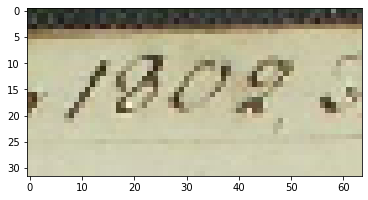

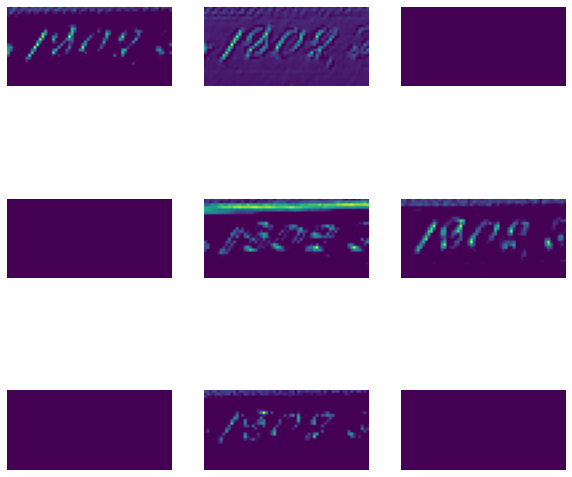

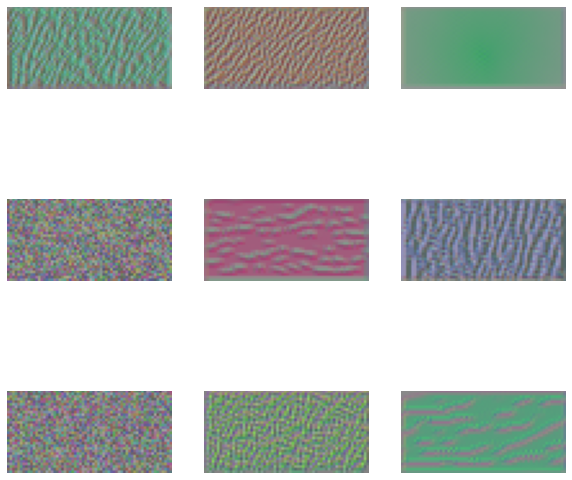

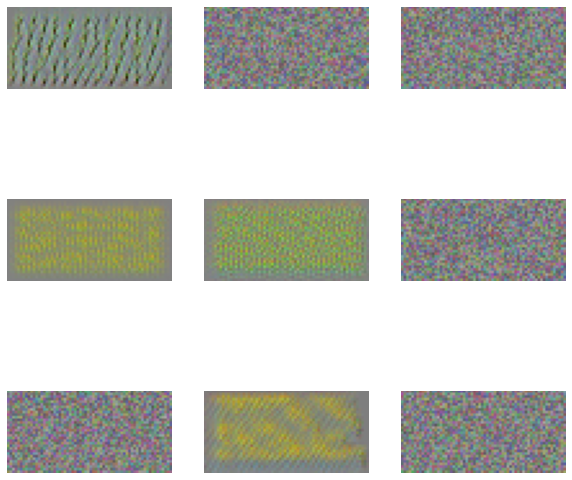

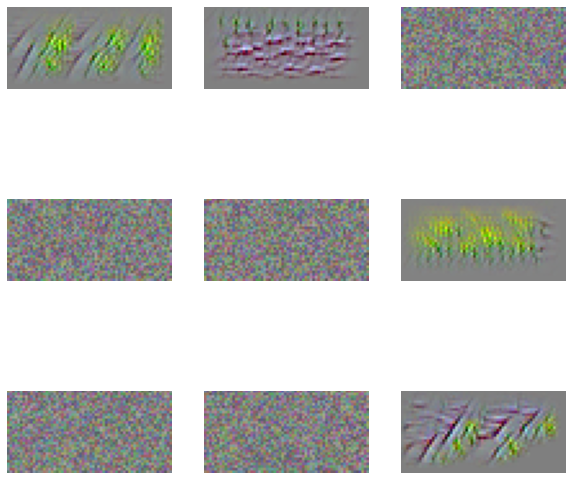

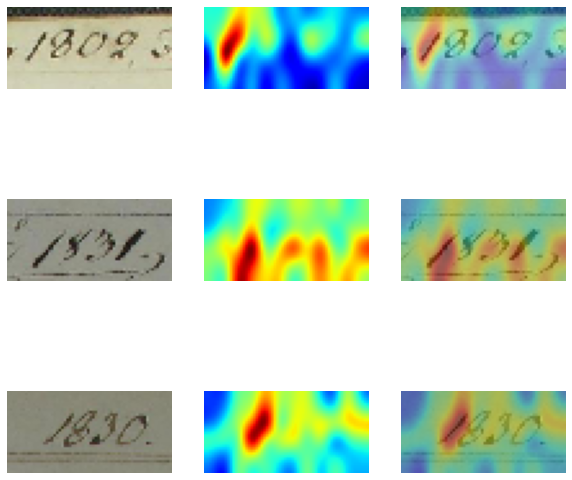

In [801]:
# Heatmaps & visualizations of activations

from keras.preprocessing import image
from tqdm import tqdm

def image_files(input_directory):
    filepaths=[]
    digit_folders=os.listdir(input_directory)
        
    for digit in digit_folders:
        path=os.path.join(input_directory, digit)
        flist=os.listdir(path)
        for f in flist:
            fpath=os.path.join(path,f)        
            filepaths.append(fpath) 
    return filepaths

def load_images(filepaths):
    images = []
    for i in tqdm(range(len(filepaths))):
        img = image.load_img(filepaths[i], target_size=(32,64,3), grayscale=False)
        img = image.img_to_array(img)
        img.astype('float32')
        img = img/255
        images.append(img)

    images = np.array(images)
    return images

filepaths = image_files("./DIDA_12000_String_Digit_Images/cell_image/train/")

images = load_images(filepaths)

train_images = images
example_image = train_images[0:1].copy()
plt.imshow(example_image[0])

modelCC.summary()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); 
    plt.axis('off'); 
    plt.imshow(modelCC.get_layer('conv2d_368')(example_image)[0, :, :, i])

    
def tidy_image(image):
    image = image.numpy()[0]
    image -= image.mean()
    image /= (image.std() + 0.00001)
    image *= 0.1
    image += 0.5
    image = np.clip(image, 0, 1)
        
    return image


def generate_pattern(layer_name, filter_index, im_size):
    submodel = tf.keras.models.Model([modelCC.inputs], [modelCC.get_layer(layer_name).output])

    input_img_data = np.random.random((1, *im_size))
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    for _ in range(100):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * 1.0)
        
    return tidy_image(input_img_data)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(generate_pattern('conv2d_368', i, (32, 64, 3)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(generate_pattern('conv2d_369', i, (32, 64, 3)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(generate_pattern('conv2d_370', i, (32, 64, 3)))

class_names=['0','1']

def get_heatmap(category, start_image):
    CC_output     = modelCC.get_layer('dense_206').output # output layer
    last_conv_layer = modelCC.get_layer('conv2d_370').output # deep convolution 
                                                      
    submodel = tf.keras.models.Model([modelCC.inputs], [CC_output, last_conv_layer])

    input_img_data = start_image.copy()
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    with tf.GradientTape() as tape:
        outputs_class, outputs_conv = submodel(input_img_data)
        loss_value                  = tf.reduce_mean(outputs_class[:, category])

    grads = tape.gradient(loss_value, outputs_conv)

    cast_outputs_conv = tf.cast(outputs_conv > 0, "float32")
    cast_grads        = tf.cast(grads > 0, "float32")
    guided_grads      = cast_outputs_conv * cast_grads * grads
    outputs_conv      = outputs_conv[0]
    guided_grads      = guided_grads[0]
    
    weights           = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam               = tf.reduce_sum(tf.multiply(weights, outputs_conv), axis=-1)
    
    return cam

from PIL import Image

cmap = plt.get_cmap('jet')
train_labels_1=real_labels_CC
train_labels_1=[int(g) for g in train_labels_1]
train_labels_1=np.array(train_labels_1)

def create_heatmap(idx):
    category, image = train_labels_1[idx], train_images[idx:(idx + 1)]

    heatmap = get_heatmap(category, image)
    heatmap = heatmap.numpy()
    heatmap = Image.fromarray(heatmap)
    heatmap = heatmap.resize((64, 32), Image.ANTIALIAS) # upscale
    heatmap = np.array(heatmap) # back to numpy array
    heatmap = (heatmap / heatmap.max()) # to [0, 1]    
    heatmap = cmap(heatmap)
    heatmap = np.delete(heatmap, 3, 2)

    overlayed_heatmap = 0.6 * image[0] + 0.4 * heatmap
    
    return image[0], heatmap, overlayed_heatmap

def plot_heatmap():
    plt.figure(figsize=(10, 10))
    for i in range(3):
        images = create_heatmap(i)
        for j in range(3):
            ax = plt.subplot(3, 3, i * 3 + 1 + j); plt.axis('off'); plt.imshow(images[j])
    plt.show()
plot_heatmap()

